# Behavioral Segmentation #

OBJECTIVE: identification of segments which are homogenous in therms of needs, behavior and attitudes

METHOD:
- reduce the dimension of the input information (factor analysis)
- identify segments wich are internally homogeneous (minimize within sum of squares), but different among them (cluster analysis)
- cluster profiling and cluster description

BUSINESS CASE: Disneyland Milan  

Will the opening of a Disneyland them park in Milan be succesful?
- web survey (target population: 18-55 yo, living in Lombardy)
- investigate the ideal configuration of the theme park
- segment the population to find the consumers that are more likely to go in Disneyland Milan (today's goal)


### Import libraries ###

In [2]:
!pip install factor_analyzer


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\Matteo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

import seaborn as sb
from matplotlib import pyplot as plt

import os

from factor_analyzer import FactorAnalyzer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

import scipy.stats as stats

### Import data ###

In [4]:
survey = pd.read_sas(r'disneyland.sas7bdat',format='sas7bdat')

In [5]:
survey.shape

(203, 84)

In [6]:
survey.columns

Index(['id', 'Q1', 'Q2_1', 'Q2_2', 'Q2_3', 'Q2_4', 'Q2_5', 'Q3_1', 'Q3_2',
       'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q5', 'Q6_1', 'Q6_2', 'Q6_3',
       'Q6_4', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_7', 'Q7_8',
       'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q9_1', 'Q9_2', 'Q9_3', 'Q9_4', 'Q9_5',
       'Q9_6', 'Q9_7', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6',
       'Q10_7', 'Q4_1', 'Q11', 'Q12', 'Q13', 'Q14_1', 'Q14_2', 'Q14_3',
       'Q14_4', 'Q14_5', 'Q14_6', 'Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q15',
       'Q17', 'Q18', 'Score_1', 'Score_2', 'Score_3', 'Score_4', 'Score_5',
       'Score_6', 'Score_7', 'Score_8', 'Score_9', 'Q26_1', 'Q26_2', 'Q26_3',
       'Q26_4', 'Q26_5', 'Q26_6', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23',
       'filter__', 'Age_Range'],
      dtype='object')

In [7]:
survey.sample(n=5)

,id,Q1,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q3_1,Q3_2,Q3_3,...,Q26_4,Q26_5,Q26_6,Q19,Q20,Q21,Q22,Q23,filter__,Age_Range
76,77.0,b'Yes',NaN,NaN,NaN,NaN,NaN,1.0,2.0,3.0,...,7.0,8.0,10.0,b'Yes',42.0,b'Male',b'Employee',b'1',b'Not Selected',b'41-55 years old'
162,163.0,b'Yes',NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,...,10.0,10.0,10.0,b'Yes',30.0,b'Female',b'Employee',b'1',b'Not Selected',b'30-40 years old'
154,155.0,b'Yes',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,b'Yes',50.0,b'Female',b'Employee',b'None',b'Not Selected',b'41-55 years old'
110,111.0,b'Yes',NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,...,7.0,4.0,10.0,b'Yes',42.0,b'Female',b'Employee',b'2',b'Selected',b'41-55 years old'
58,59.0,b'Yes',NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,...,9.0,9.0,8.0,b'Yes',38.0,b'Male',b'Employee',b'1',b'Selected',b'30-40 years old'


### 1. Factorial Analysis ###

- Identify a few factors that summarize the initial information and that are easy to understand
- Principal Component analysis: p input variables --> p Principal Components wich satisfy the following:
	- Each PC is a linear combination of the original variables
	- The first PC has the highest possible variance, the second PC has the highest possible variance given the first PC and so on. 
    - The variance of each PC equals the eigenvalue of the input data correlation matrix, the sum of the PC variances equals the total variance of the original data. 
    - The coefficients of the linear combinations are the eigenvectors of the correlation matrix.
    - The PCs are standardized and orthogonal between each other (uncorrelated)
- Factor analysis: select only k<<p PCs (factors). Write the original data as a linear combination of the factors plus a residualterm (if k=p the residual term equals zero). The coefficients are called FACTOR LOADINGS; they equal the correlation coefficients between  factors and variables. Aim: find factors which are highly correlated with specific groups of variables: interpretation.
- How many factors?
	- eigenvalues > 1
	- percentage of variance explained by the factors between 60% and 75%
	- communalities (percentage of variance of a variable explained by all of the factors) > 0.3-0.4
    - scree plot: point at which the scree begins
    - p/k about 3

#### Correlation Analysis ### 

We first determine which questions might be useful/relevant to find out hidden factors.

In [8]:
relevant_questions = [
    "Q7_1", "Q7_2", "Q7_3", "Q7_4", "Q7_5",
    "Q9_1", "Q9_2", "Q9_3", "Q9_4", "Q9_5", "Q9_6", "Q9_7", 
    "Q10_1", "Q10_2", "Q10_3", "Q10_4", "Q10_5", "Q10_6", "Q10_7",
    "Q16_1", "Q16_2", "Q16_3", "Q16_4",
    "Q4_1", "Q17"
]

relevant_survey = survey[relevant_questions]

Let's have a look at the correlations among variables

<Axes: >

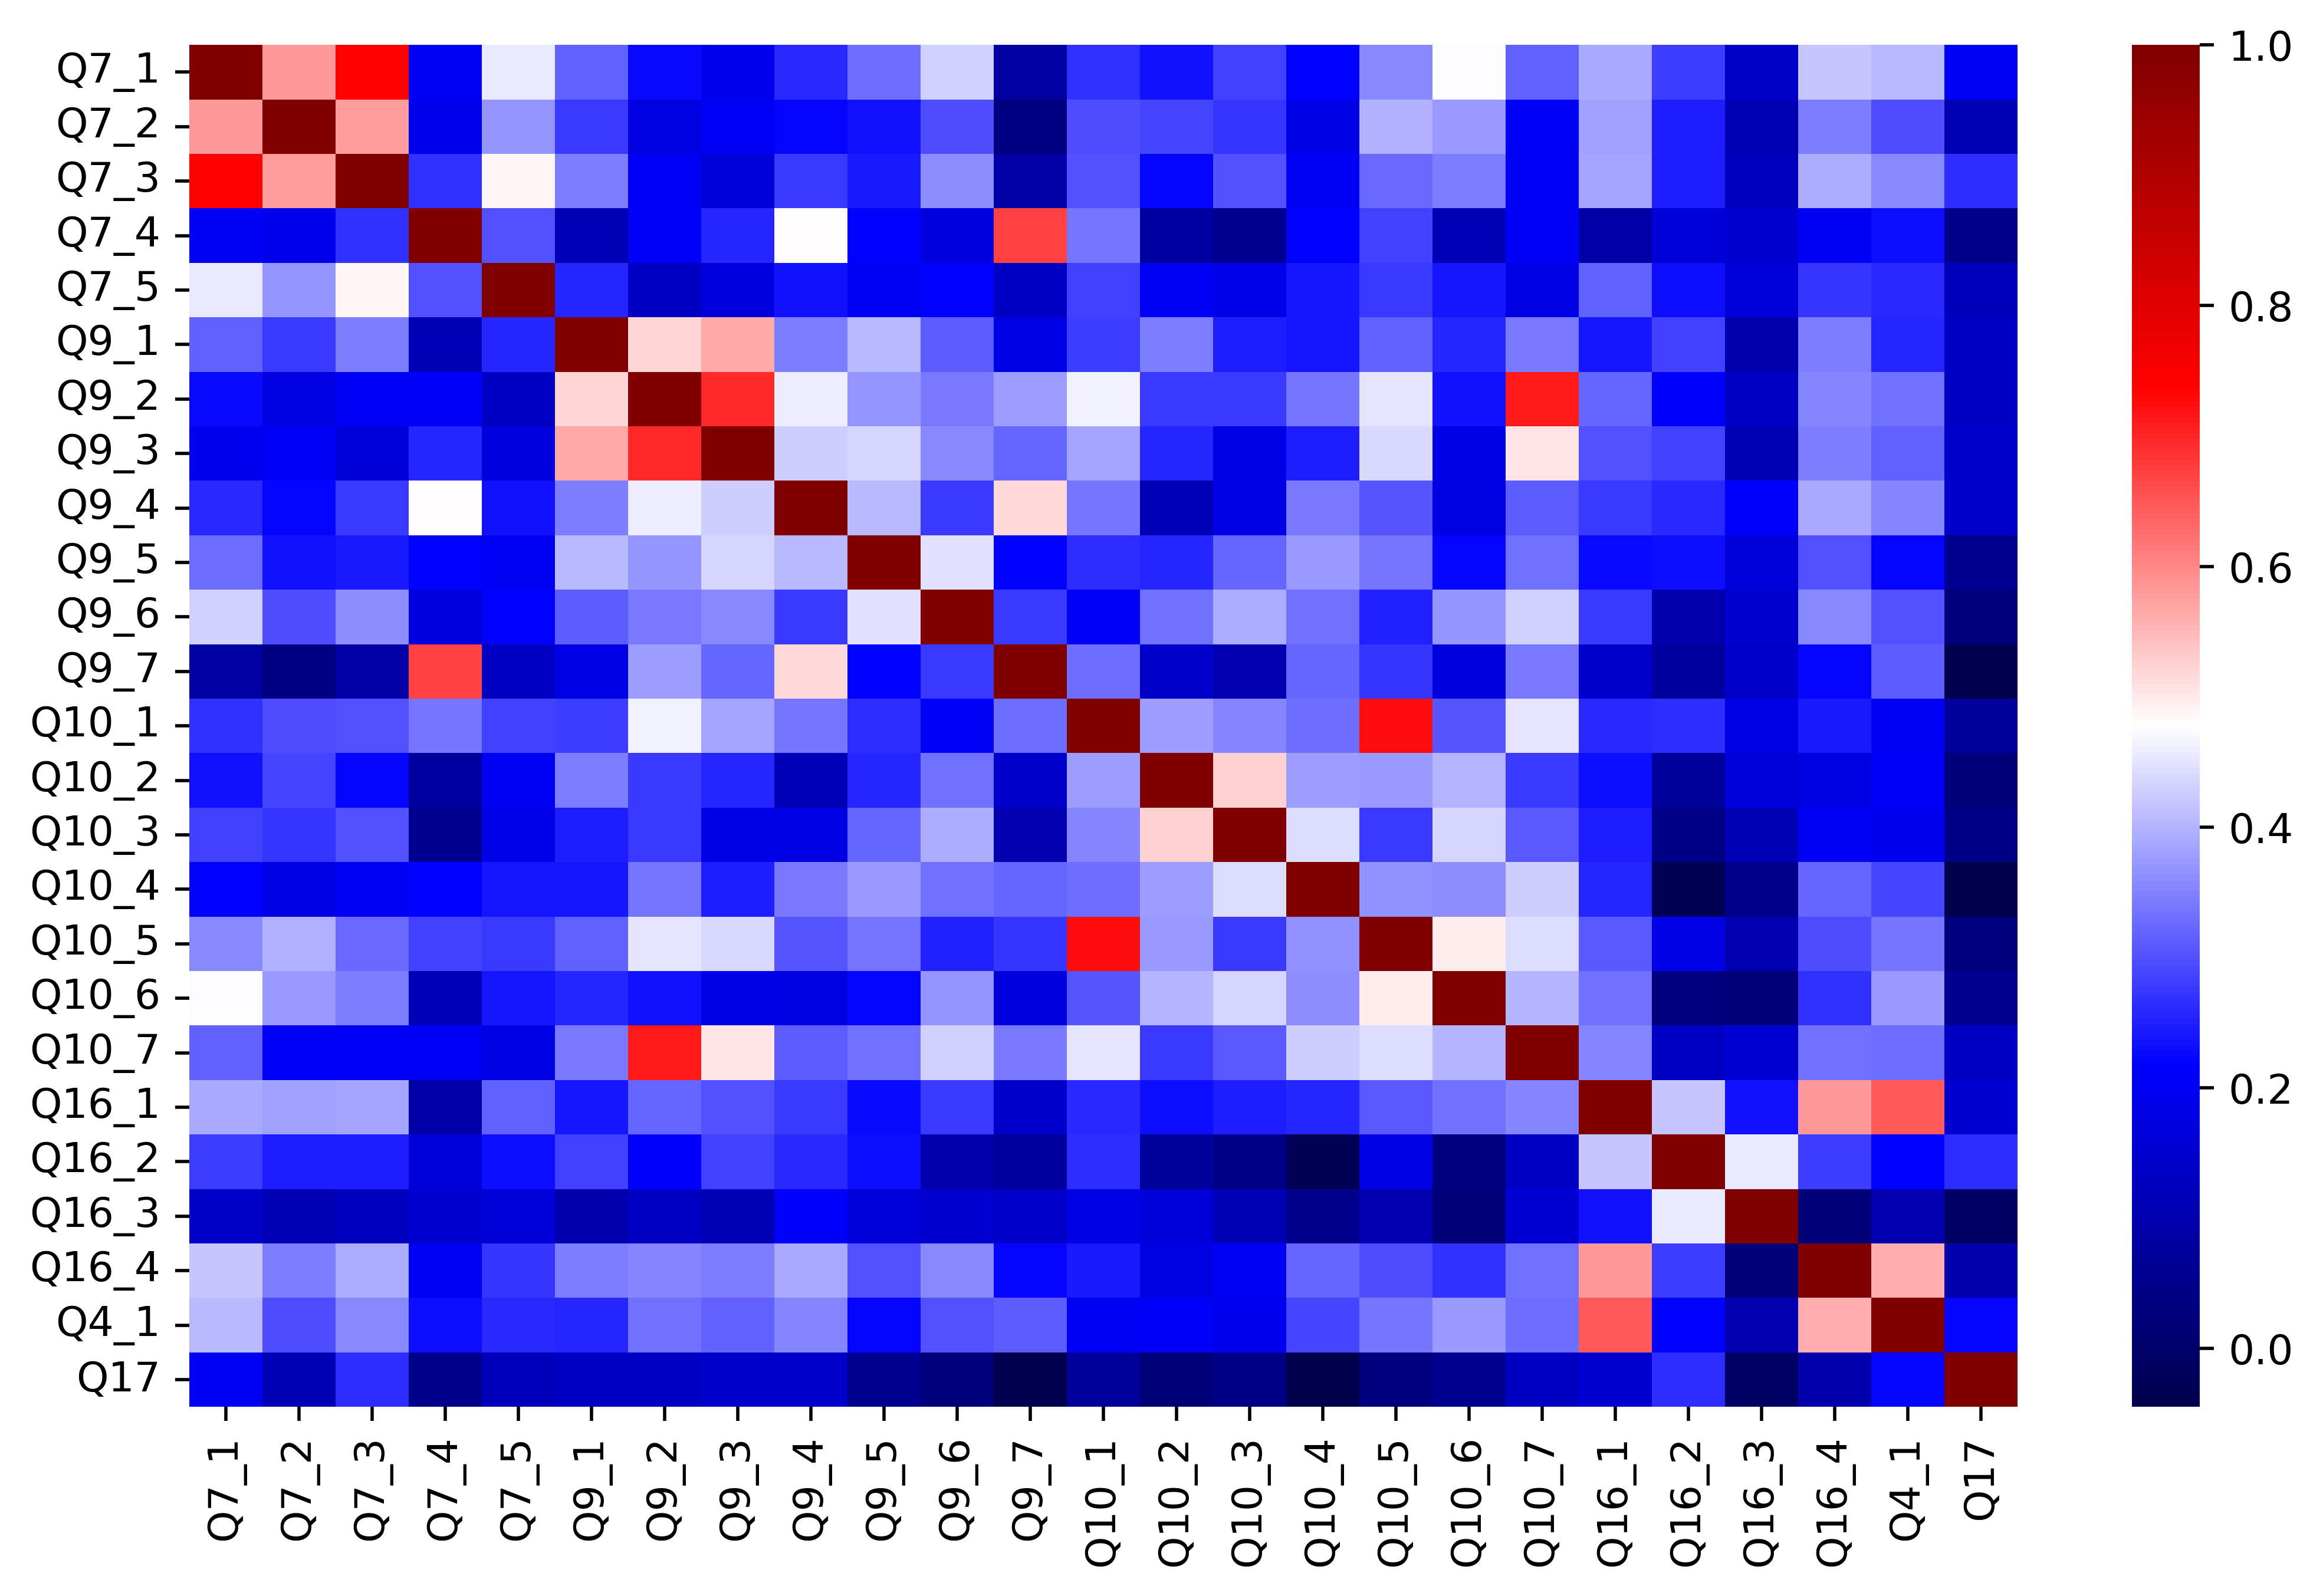

In [9]:
correlations = relevant_survey.corr()
plt.rcParams['figure.dpi'] = 500
plt.figure(figsize=(10,6))
sb.heatmap(correlations, cmap="seismic", annot=False)

The variable Q17 is very low correlated with the other variables: we exclude it from the factor analysis. 

It will be included again later in the cluster analysis.

In [10]:
##The final dataset to work with
final_survey = relevant_survey.drop(columns=["Q17"])

Let's check if there is any missing in the dataset I will use for factor analysis. 

In [11]:
final_survey.isna().sum()

Q7_1     0
Q7_2     0
Q7_3     0
Q7_4     0
Q7_5     0
Q9_1     0
Q9_2     0
Q9_3     0
Q9_4     0
Q9_5     0
Q9_6     0
Q9_7     0
Q10_1    0
Q10_2    0
Q10_3    0
Q10_4    0
Q10_5    0
Q10_6    0
Q10_7    0
Q16_1    0
Q16_2    0
Q16_3    0
Q16_4    0
Q4_1     0
dtype: int64

### Find the latent factors with FA

In [12]:
final_survey.shape

(203, 24)

Let's fit a factor model with number of components equal to the number of the variables in our dataframe. 

In [13]:
np.random.seed(33)
## First I create an object with the features I want
fa_pca = FactorAnalyzer(rotation=None, n_factors=24, method='principal')
## Then the analysis is applied to a given dataset
fa_pca.fit(final_survey)

FactorAnalyzer(method='principal', n_factors=24, rotation=None,
               rotation_kwargs={})

In [14]:
ev, _ = fa_pca.get_eigenvalues()
# ev: The eigenvalues

display(ev)


array([7.77181811, 2.14080223, 1.81299862, 1.45431907, 1.33242746,
       1.12981739, 1.11310094, 0.80562796, 0.70364904, 0.69189727,
       0.59257094, 0.56239371, 0.49688684, 0.45645798, 0.44815291,
       0.42122657, 0.35673905, 0.33784663, 0.30981031, 0.27585441,
       0.23774018, 0.2078002 , 0.17829852, 0.16176368])

Let's have a look at the scree plot. 

[Text(0.5, 0, 'Factor'), Text(0, 0.5, 'Eigenvalue')]

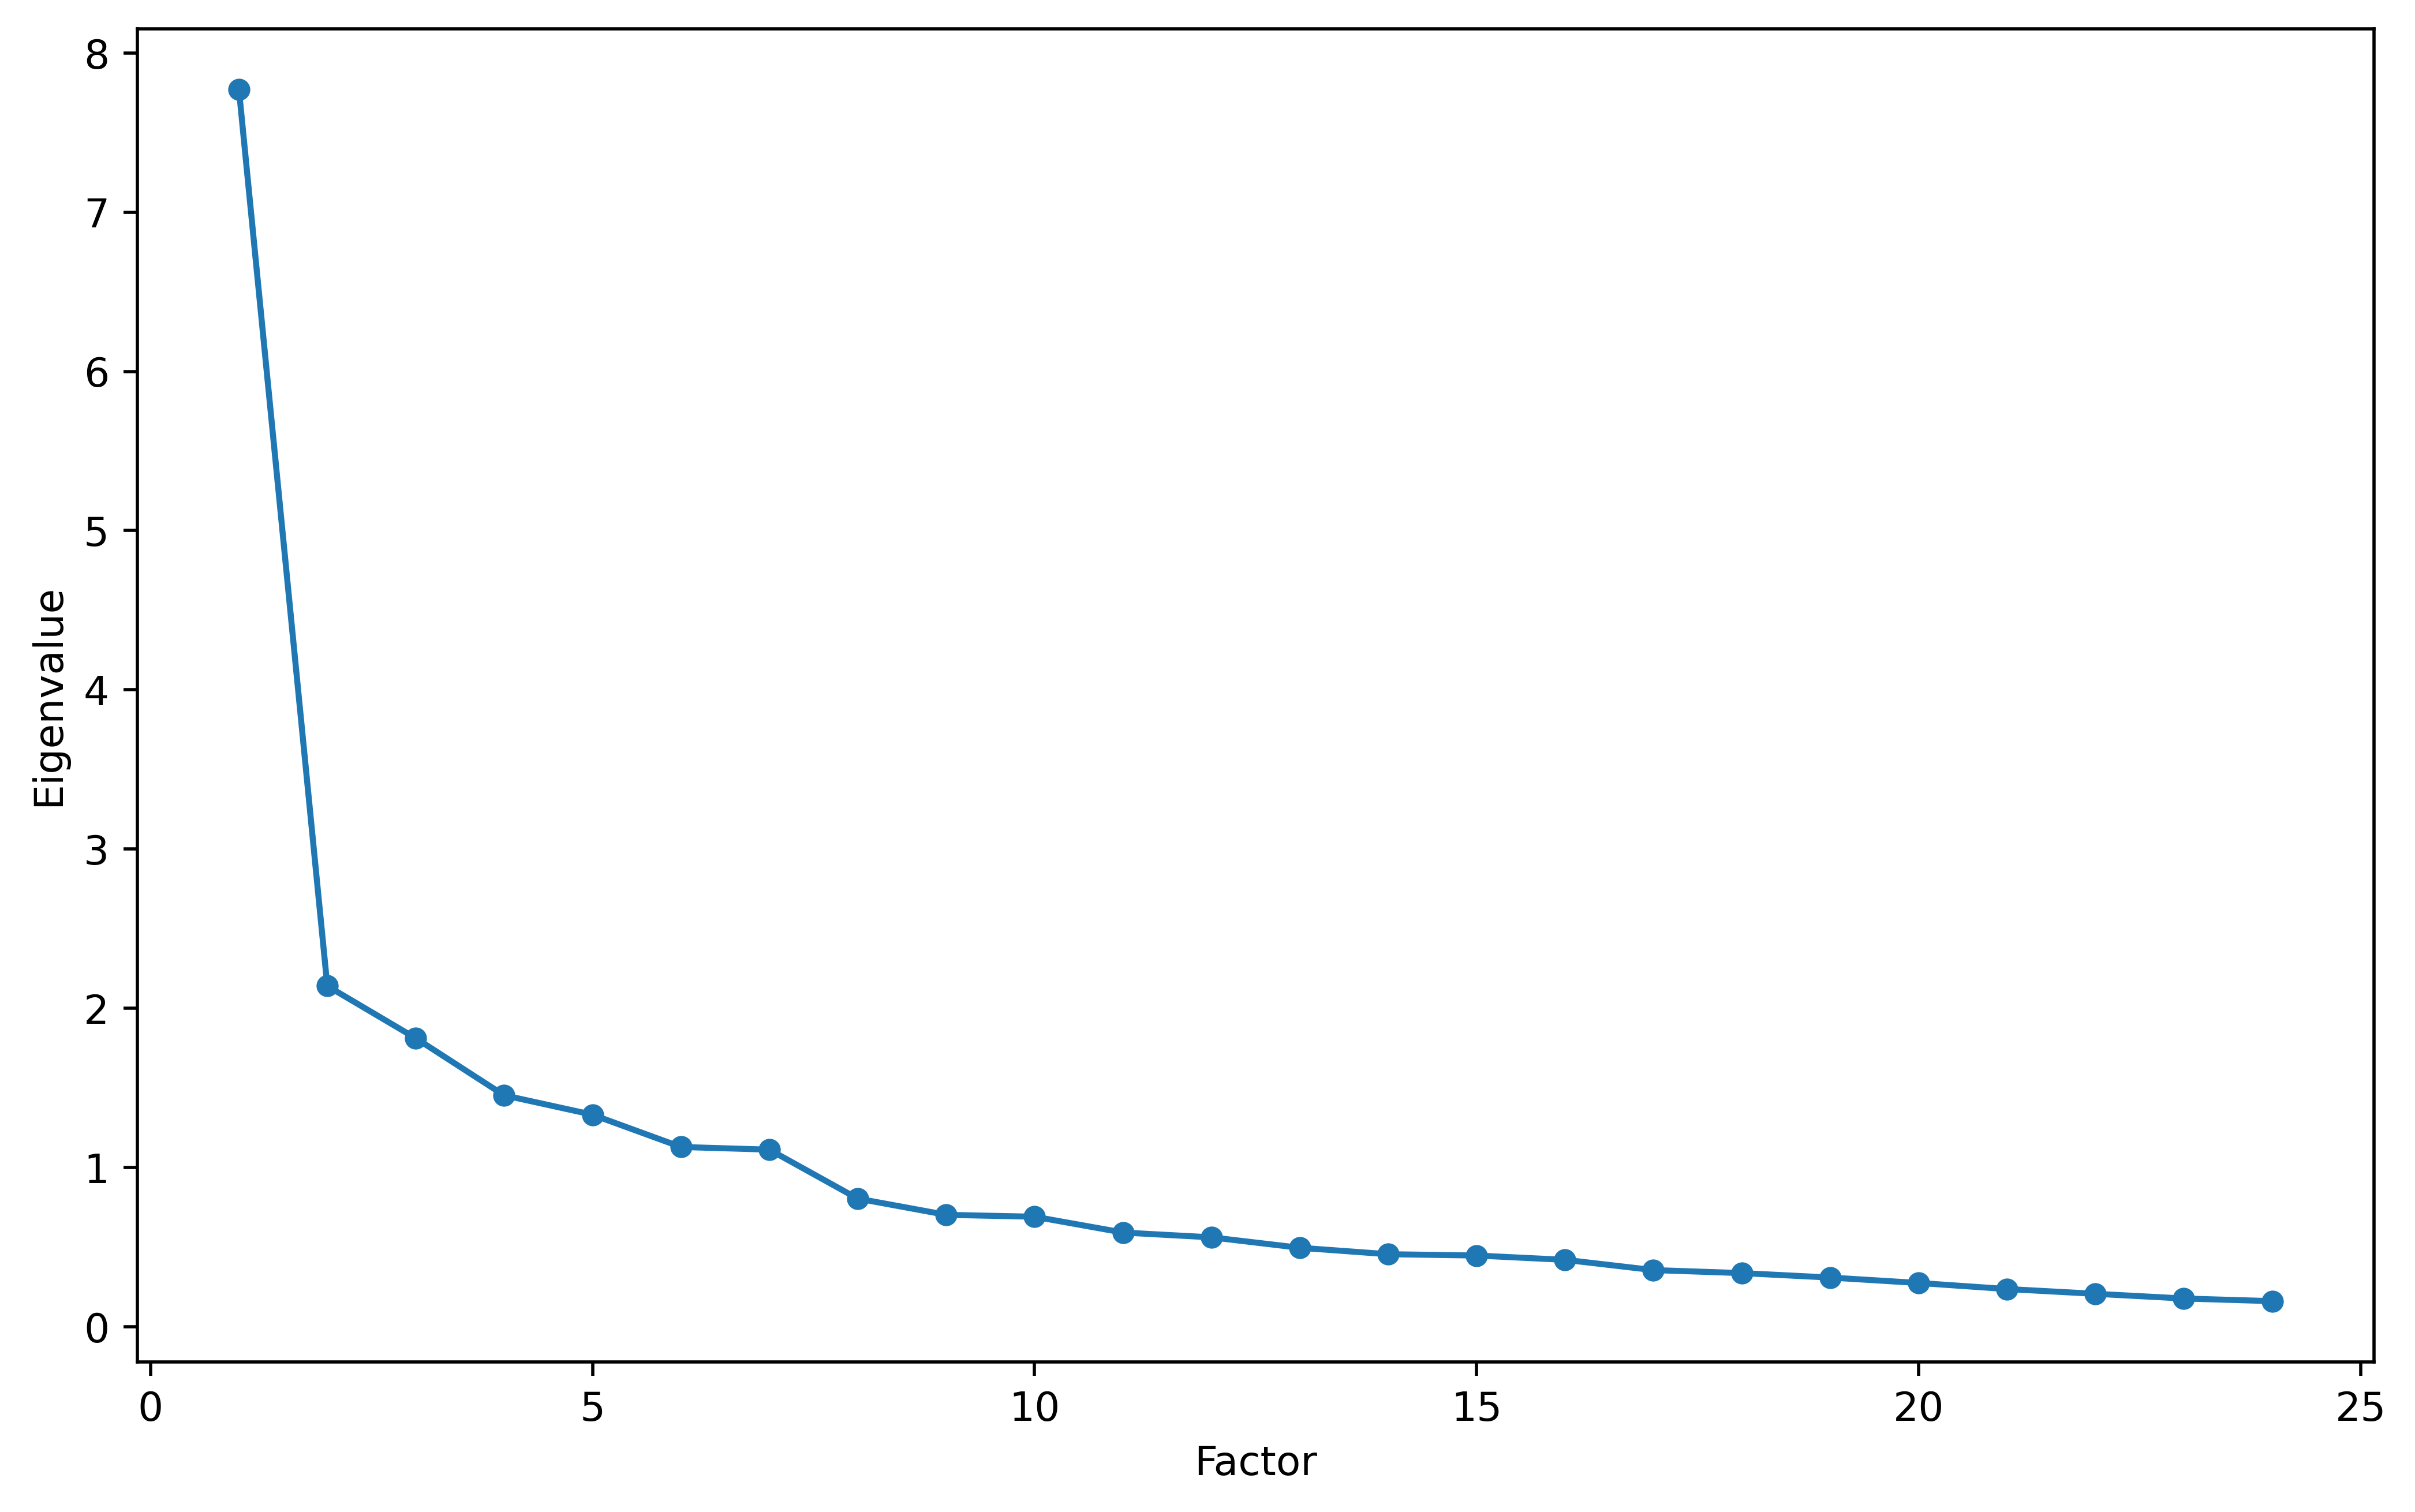

In [15]:
ev, _ = fa_pca.get_eigenvalues()
plt.rcParams['figure.dpi'] = 500
plt.figure(figsize=(10,6))
sb.scatterplot(x=range(1,final_survey.shape[1]+1),y=ev)
ax = sb.lineplot(x=range(1,final_survey.shape[1]+1), y=ev)
ax.set(xlabel="Factor", ylabel = "Eigenvalue")

Possible elbows: 2, 4, 8.

Let's see how the total variance is distributed across the components.

In [16]:
###Creo un dataser variance_data con info prodotte dall funzione FactorAnalyzer
variance_summary_data = {
    'Variance':fa_pca.get_factor_variance()[0],
    'Proportion Var':fa_pca.get_factor_variance()[1],
    'Cumulative Var': fa_pca.get_factor_variance()[2]
}
variance_summary = pd.DataFrame(data=variance_summary_data)
variance_summary

,Variance,Proportion Var,Cumulative Var
0,7.771818,0.323826,0.323826
1,2.140802,0.089200,0.413026
2,1.812999,0.075542,0.488567
3,1.454319,0.060597,0.549164
4,1.332427,0.055518,0.604682
5,1.129817,0.047076,0.651758
6,1.113101,0.046379,0.698137
7,0.805628,0.033568,0.731705
8,0.703649,0.029319,0.761023
9,0.691897,0.028829,0.789852


In [17]:
variance_summary[['Variance','Proportion Var']].sum()

Variance          24.0
Proportion Var     1.0
dtype: float64

The first seven factors explain 69.8% of the variance, are about 1/3 of the original variables, and have eigenvalue>1

Let's choose the solution with seven factors, but still without rotation. 

In [18]:
np.random.seed(33)
n_factors = 7
##The object with the result of the PCA without rotation
fa_no_rotation = FactorAnalyzer(n_factors, rotation=None, method='principal')

fa_no_rotation.fit(final_survey)

FactorAnalyzer(method='principal', n_factors=7, rotation=None,
               rotation_kwargs={})

In [19]:
###Come prima, estraggo gli eigenvalue dall'oggetto fa_no_rotation che ha le componenti principali
ev, _ = fa_no_rotation.get_eigenvalues()
###Mi creo una partizione dove salvo solo i valori degli eigenvalue dei primi 7 fattori
df_eigenvals = pd.DataFrame({"Eigenvalues":ev}).iloc[:7]

###Creo un output variance_data per riassumere le info prodotte dall funzione FactorAnalyzer riguardo la varianza
variance_data = {
    'Variance':fa_no_rotation.get_factor_variance()[0],
    'Proportion Var':fa_no_rotation.get_factor_variance()[1],
    'Cumulative Var': fa_no_rotation.get_factor_variance()[2]
}
### Creo un dataset variance_data con info prodotte dall funzione FactorAnalyzer
df_variance = pd.DataFrame(data=variance_data)

### Metto assieme le info di autovalori e varianza e dei primi 7 fattori estratti per facilitare l'interpretazione.
df_tot=df_eigenvals.join(df_variance)
df_tot

,Eigenvalues,Variance,Proportion Var,Cumulative Var
0,7.771818,7.771818,0.323826,0.323826
1,2.140802,2.140802,0.089200,0.413026
2,1.812999,1.812999,0.075542,0.488567
3,1.454319,1.454319,0.060597,0.549164
4,1.332427,1.332423,0.055518,0.604682
5,1.129817,1.129814,0.047076,0.651757
6,1.113101,1.113097,0.046379,0.698136


### Compute the communalities

In [20]:
# Communalities
communalities = fa_no_rotation.get_communalities()
df_communalities = pd.DataFrame({"Communalities":communalities})
display(df_communalities)

,Communalities
0,0.754364
1,0.624746
2,0.761933
3,0.815778
4,0.493491
5,0.653355
6,0.786070
7,0.764793
8,0.635052
9,0.590723


Let's see the factor pattern of the unrotated solution

In [21]:
## Factor loading matrix extraction from the object fa_no_rotation plus loadings rounding
unrotated_factor_pattern = pd.DataFrame(
    data=np.round(100*fa_no_rotation.loadings_,0), 
    index=final_survey.columns, 
    columns=["Factor_" + str(i+1) for i in range(n_factors)]
)
display(unrotated_factor_pattern)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
Q7_1,64.0,52.0,8.0,9.0,-2.0,13.0,-19.0
Q7_2,56.0,49.0,4.0,9.0,12.0,-3.0,-22.0
Q7_3,61.0,52.0,14.0,17.0,4.0,13.0,-23.0
Q7_4,44.0,-31.0,38.0,61.0,7.0,6.0,-3.0
Q7_5,49.0,33.0,19.0,25.0,16.0,7.0,-12.0
Q9_1,59.0,-10.0,-2.0,-36.0,5.0,23.0,-33.0
Q9_2,67.0,-44.0,-6.0,-31.0,-5.0,-9.0,-17.0
Q9_3,63.0,-41.0,5.0,-35.0,-2.0,1.0,-27.0
Q9_4,60.0,-33.0,33.0,16.0,-8.0,18.0,0.0
Q9_5,57.0,-14.0,-5.0,-14.0,5.0,46.0,-4.0


Let's rotate the pattern: we want a rotated solution with seven components.

In [22]:
## Repeat the previous call adding the request of performing a varimax rotation (minimize the number of variables highly 
## correlated with the same factor)
np.random.seed(33)
fa = FactorAnalyzer(n_factors=7, rotation="varimax", method='principal')
fa.fit(final_survey)

FactorAnalyzer(method='principal', n_factors=7, rotation='varimax',
               rotation_kwargs={})

The pattern will be clearer!

In [23]:
rotated_factor_pattern_nofilter = pd.DataFrame(
    data=np.round(100*fa.loadings_,0), 
    index=final_survey.columns, 
    columns=["Factor_" + str(i+1) for i in range(n_factors)]
)
display(rotated_factor_pattern_nofilter)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
Q7_1,16.0,79.0,20.0,3.0,25.0,3.0,3.0
Q7_2,10.0,72.0,14.0,-3.0,16.0,21.0,6.0
Q7_3,11.0,83.0,13.0,9.0,17.0,5.0,4.0
Q7_4,3.0,24.0,-3.0,85.0,-1.0,16.0,7.0
Q7_5,2.0,63.0,9.0,21.0,8.0,12.0,15.0
Q9_1,74.0,28.0,13.0,-2.0,5.0,7.0,8.0
Q9_2,74.0,-5.0,16.0,18.0,25.0,35.0,3.0
Q9_3,80.0,3.0,4.0,16.0,17.0,25.0,7.0
Q9_4,39.0,16.0,6.0,62.0,20.0,2.0,15.0
Q9_5,57.0,22.0,36.0,21.0,-0.0,-14.0,15.0


### To make the pattern even more clear, we erase the small loadings from the visualization

In [24]:
rotated_factor_pattern=rotated_factor_pattern_nofilter.copy()

rotated_factor_pattern[abs(rotated_factor_pattern) < 40] = ""
rotated_factor_pattern.sort_values(by=list(rotated_factor_pattern.columns), ascending=True, inplace=True)
display(rotated_factor_pattern)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_15372\4162317709.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rotated_factor_pattern[abs(rotated_factor_pattern) < 40] = ""


,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
Q10_7,50.0,,,,,,
Q9_5,57.0,,,,,,
Q9_1,74.0,,,,,,
Q9_2,74.0,,,,,,
Q9_3,80.0,,,,,,
Q7_5,,63.0,,,,,
Q7_2,,72.0,,,,,
Q7_1,,79.0,,,,,
Q7_3,,83.0,,,,,
Q9_6,,,53.0,,,,


In [25]:
## Add the question labels to our pattern to get an insight

In [26]:
dict_labels = {
    "Q7_1": "Which reasons would drive you into a theme park? (For entertainment)",
    "Q7_2": "Which reasons would drive you into a theme park? (Free time)",
    "Q7_3": "Which reasons would drive you into a theme park? (Attractions)",
    "Q7_4": "Which reasons would drive you into a theme park? (Live shows and events)",
    "Q7_5": "Which reasons would drive you into a theme park? (The whole experience)",
    "Q9_1": "What would increase your willingness to go to a theme park? (Cafe and restaurants)",
    "Q9_2": "What would increase your willingness to go to a theme park? (Resort hotels)",
    "Q9_3": "What would increase your willingness to go to a theme park? (Shops)",
    "Q9_4": "What would increase your willingness to go to a theme park? (Characters mask)",
    "Q9_5": "What would increase your willingness to go to a theme park? (Parking lots)",
    "Q9_6": "What would increase your willingness to go to a theme park? (Public means of transportation)",
    "Q9_7": "What would increase your willingness to go to a theme park? (Additional entertainment activities)",
    "Q10_1": "What would increase your willingness to go to a theme park? (Seasonal tickets)",
    "Q10_2": "What would increase your willingness to go to a theme park? (Afternoon tickets)",
    "Q10_3": "What would increase your willingness to go to a theme park? (Group tickets)",
    "Q10_4": "What would increase your willingness to go to a theme park? (Family packages)",
    "Q10_5": "What would increase your willingness to go to a theme park? (Loyalty programs)",
    "Q10_6": "What would increase your willingness to go to a theme park? (Tickets purchase through supermarkets)",
    "Q10_7": "What would increase your willingness to go to a theme park? (Park + Hotel bundle)",
    "Q4_1":  "How much do you like Disney?",
    "Q16_1": "How much do you agree with the following statements with regard to Disneyland? (I like Disneyland)",
    "Q16_2": "How much do you agree with the following statements with regard to Disneyland? (Entry prices are fair)",
    "Q16_3": "How much do you agree with the following statements with regard to Disneyland? (Easy to reach)",
    "Q16_4": "How much do you agree with the following statements with regard to Disneyland? (I would go more often if it were present in Italy)"
}

df_labels = pd.DataFrame.from_dict(dict_labels, orient='index', columns=["label"])

In [27]:
pd.options.display.max_colwidth=300
rotated_factor_pattern_labeled = (
    df_labels
    .join(rotated_factor_pattern)
    .sort_values(by=list(rotated_factor_pattern), ascending=True)
)
display(rotated_factor_pattern_labeled)

,label,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
Q10_7,What would increase your willingness to go to a theme park? (Park + Hotel bundle),50.0,,,,,,
Q9_5,What would increase your willingness to go to a theme park? (Parking lots),57.0,,,,,,
Q9_1,What would increase your willingness to go to a theme park? (Cafe and restaurants),74.0,,,,,,
Q9_2,What would increase your willingness to go to a theme park? (Resort hotels),74.0,,,,,,
Q9_3,What would increase your willingness to go to a theme park? (Shops),80.0,,,,,,
Q7_5,Which reasons would drive you into a theme park? (The whole experience),,63.0,,,,,
Q7_2,Which reasons would drive you into a theme park? (Free time),,72.0,,,,,
Q7_1,Which reasons would drive you into a theme park? (For entertainment),,79.0,,,,,
Q7_3,Which reasons would drive you into a theme park? (Attractions),,83.0,,,,,
Q9_6,What would increase your willingness to go to a theme park? (Public means of transportation),,,53.0,,,,


In [28]:
#scegliamo il fattore da assegnare alla variabile prendendo quello con valore assoluto più alto
rotated_factor_pattern_nofilter.abs().idxmax(axis="columns",skipna=True).sort_values()

Q10_7    Factor_1
Q9_1     Factor_1
Q9_2     Factor_1
Q9_3     Factor_1
Q9_5     Factor_1
Q7_1     Factor_2
Q7_2     Factor_2
Q7_3     Factor_2
Q7_5     Factor_2
Q10_6    Factor_3
Q9_6     Factor_3
Q10_4    Factor_3
Q10_3    Factor_3
Q10_2    Factor_3
Q9_7     Factor_4
Q9_4     Factor_4
Q7_4     Factor_4
Q16_4    Factor_5
Q16_1    Factor_5
Q4_1     Factor_5
Q10_5    Factor_6
Q10_1    Factor_6
Q16_2    Factor_7
Q16_3    Factor_7
dtype: object

#### Assinging labels to the factors: ####

- FACTOR_1 (Q10_7, Q9_5, Q9_2, Q9_1, Q9_3): On-site services
- FACTOR_2 (Q7_3,Q7_1, Q7_2, Q7_5): Entertainment
- FACTOR_3 (Q10_6, Q10_4, Q10_2, Q10_3, Q9_6): Convenience
- FACTOR_4 (Q9_7, Q7_4, Q9_4): Additional activities
- FACTOR_5 (Q16_4, Q16_1, Q4_1): Love for Disney (Disney Mania)
- FACTOR_6 (Q10_1, Q10_5): Loyalty
- FACTOR_7 (Q16_3, Q16_2): Disneyland's accessibility


# 2. Cluster Analysis ###

#### Data Preparation ####

We get the factor scores for our dataset and use this transformed set as input for clustering

In [29]:
## Running the above code, we will have the object FA which host informations needed to perform a PCA to extract 7 factors with 
##Varimax rotation.

new_variables = fa.transform(final_survey)
## We apply the method .transform to create a new dataset with the factors: each observation will have seven variables:
## the corrensponding factor values calculated on the basis of the 24 original variables in final_survey

## The loops gives a new name to the added factor: Factor+cardinal number
transformed_df = pd.DataFrame(
    data = new_variables,
    columns=["Factor_" + str(i+1) for i in range(n_factors)]
)

In [30]:
display(final_survey.shape)
final_survey.head(100)

(203, 24)

,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q9_1,Q9_2,Q9_3,Q9_4,Q9_5,...,Q10_3,Q10_4,Q10_5,Q10_6,Q10_7,Q16_1,Q16_2,Q16_3,Q16_4,Q4_1
0,10.0,10.0,10.0,7.0,10.0,4.0,1.0,3.0,8.0,6.0,...,2.0,9.0,9.0,10.0,5.0,6.0,5.0,1.0,10.0,10.0
1,7.0,1.0,3.0,1.0,1.0,8.0,9.0,8.0,1.0,6.0,...,8.0,5.0,4.0,8.0,8.0,1.0,8.0,7.0,1.0,10.0
2,3.0,3.0,4.0,4.0,1.0,3.0,4.0,4.0,4.0,5.0,...,5.0,7.0,2.0,7.0,7.0,10.0,2.0,2.0,4.0,10.0
3,8.0,8.0,10.0,5.0,5.0,10.0,9.0,6.0,6.0,10.0,...,5.0,9.0,4.0,9.0,8.0,7.0,8.0,5.0,7.0,6.0
4,10.0,10.0,10.0,5.0,7.0,10.0,10.0,7.0,9.0,6.0,...,8.0,8.0,5.0,6.0,7.0,10.0,3.0,1.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.0,1.0,10.0,10.0,1.0,6.0,1.0,1.0,10.0,1.0,...,1.0,1.0,1.0,10.0,4.0,1.0,1.0,1.0,10.0,10.0
96,6.0,7.0,5.0,3.0,3.0,5.0,5.0,5.0,3.0,7.0,...,4.0,5.0,6.0,6.0,7.0,6.0,4.0,2.0,8.0,6.0
97,10.0,4.0,7.0,6.0,10.0,5.0,5.0,5.0,7.0,5.0,...,8.0,8.0,8.0,8.0,8.0,9.0,7.0,5.0,10.0,9.0
98,6.0,4.0,5.0,5.0,6.0,7.0,7.0,5.0,4.0,8.0,...,7.0,4.0,5.0,7.0,8.0,5.0,3.0,3.0,8.0,8.0


In [31]:
transformed_df

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,-1.507602,1.739829,-1.582117,1.486606,0.348283,1.062008,-1.556853
1,1.391487,-2.544854,0.984515,-1.204240,-1.370118,0.007769,0.981328
2,-0.931165,-2.799004,-0.064289,0.000878,1.282488,-0.194460,-0.795617
3,1.563886,0.255569,0.096038,0.181109,-1.236924,-0.503823,0.354931
4,0.808124,0.591422,-0.818061,0.075789,0.622085,0.926356,-1.233772
...,...,...,...,...,...,...,...
198,0.486259,-0.076275,-1.558078,0.818222,0.873873,0.119851,1.465061
199,-1.292255,-1.183594,0.518441,1.576729,-0.281000,0.320677,0.382433
200,1.193853,-0.144894,1.435313,-2.705499,0.832958,1.654618,-1.911176
201,-0.596000,0.346759,-0.287994,1.060295,-0.202027,-1.507918,0.877398


In [32]:
display(transformed_df.shape)
transformed_df.head(300)

(203, 7)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,-1.507602,1.739829,-1.582117,1.486606,0.348283,1.062008,-1.556853
1,1.391487,-2.544854,0.984515,-1.204240,-1.370118,0.007769,0.981328
2,-0.931165,-2.799004,-0.064289,0.000878,1.282488,-0.194460,-0.795617
3,1.563886,0.255569,0.096038,0.181109,-1.236924,-0.503823,0.354931
4,0.808124,0.591422,-0.818061,0.075789,0.622085,0.926356,-1.233772
...,...,...,...,...,...,...,...
198,0.486259,-0.076275,-1.558078,0.818222,0.873873,0.119851,1.465061
199,-1.292255,-1.183594,0.518441,1.576729,-0.281000,0.320677,0.382433
200,1.193853,-0.144894,1.435313,-2.705499,0.832958,1.654618,-1.911176
201,-0.596000,0.346759,-0.287994,1.060295,-0.202027,-1.507918,0.877398


New transformed variables are already standardized, let's check it:

In [33]:
Factor_means = []
Factor_stds = []

for i in range(6):
    Factor_means.append(np.mean(transformed_df.iloc[:,i]))
    Factor_stds.append(np.std(transformed_df.iloc[:,i]))

print(Factor_means)
print(Factor_stds)
print(np.round(Factor_means))
print(np.round(Factor_stds))

[3.500210520985715e-17, -1.635254602773014e-16, 2.0782499968352683e-17, 9.625578932710717e-17, -3.500210520985715e-17, 6.125368411725002e-17]
[0.9999992084568217, 0.9999988042766836, 1.000001737953209, 0.9999999975162482, 0.9999983102124417, 0.9999959832549999]
[ 0. -0.  0.  0. -0.  0.]
[1. 1. 1. 1. 1. 1.]


We add the variable Q17, previously eliminated from the factorial analysis, and we standardize it: that is the variable Q17_std.

In [34]:
transformed_df = transformed_df.join(relevant_survey[["Q17"]])

transformed_df["Q17_std"] = (
    (transformed_df["Q17"]-transformed_df["Q17"].mean())/transformed_df["Q17"].std()
)

transformed_df.drop(columns=["Q17"],inplace=True) # we do not need Q17 anymore


print(transformed_df["Q17_std"].mean()) #sanity-check of the mean of the standardized variable
print(transformed_df["Q17_std"].std()) #sanity-check of the std of the standardized variable

-1.0500631562957145e-16
1.0


In [35]:
# This is the dataset we will use to do the clustering analysis
transformed_df.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std
0,-1.507602,1.739829,-1.582117,1.486606,0.348283,1.062008,-1.556853,0.544491
1,1.391487,-2.544854,0.984515,-1.204240,-1.370118,0.007769,0.981328,-0.775290
2,-0.931165,-2.799004,-0.064289,0.000878,1.282488,-0.194460,-0.795617,-0.775290
3,1.563886,0.255569,0.096038,0.181109,-1.236924,-0.503823,0.354931,-0.775290
4,0.808124,0.591422,-0.818061,0.075789,0.622085,0.926356,-1.233772,-0.115400


In [36]:
transformed_df.isna().sum()

Factor_1    0
Factor_2    0
Factor_3    0
Factor_4    0
Factor_5    0
Factor_6    0
Factor_7    0
Q17_std     0
dtype: int64

# METHOD 1 (recommended for large datasets) ###
- aggloremative  clustering on a random subset of the original data
- selection of the optimal number of clusters (maximum cluster distances)
- save the final cluster centroids
- run a k-means clustering where the inizial cluster centroids are 
  setted equal to the centroids calculated in the previous step

In [37]:
# we take a random subset of data 
np.random.seed(42)
sample = transformed_df.sample(frac=0.33, replace=False)

print(len(sample))


67


Let's draw a dendrogram using ward method

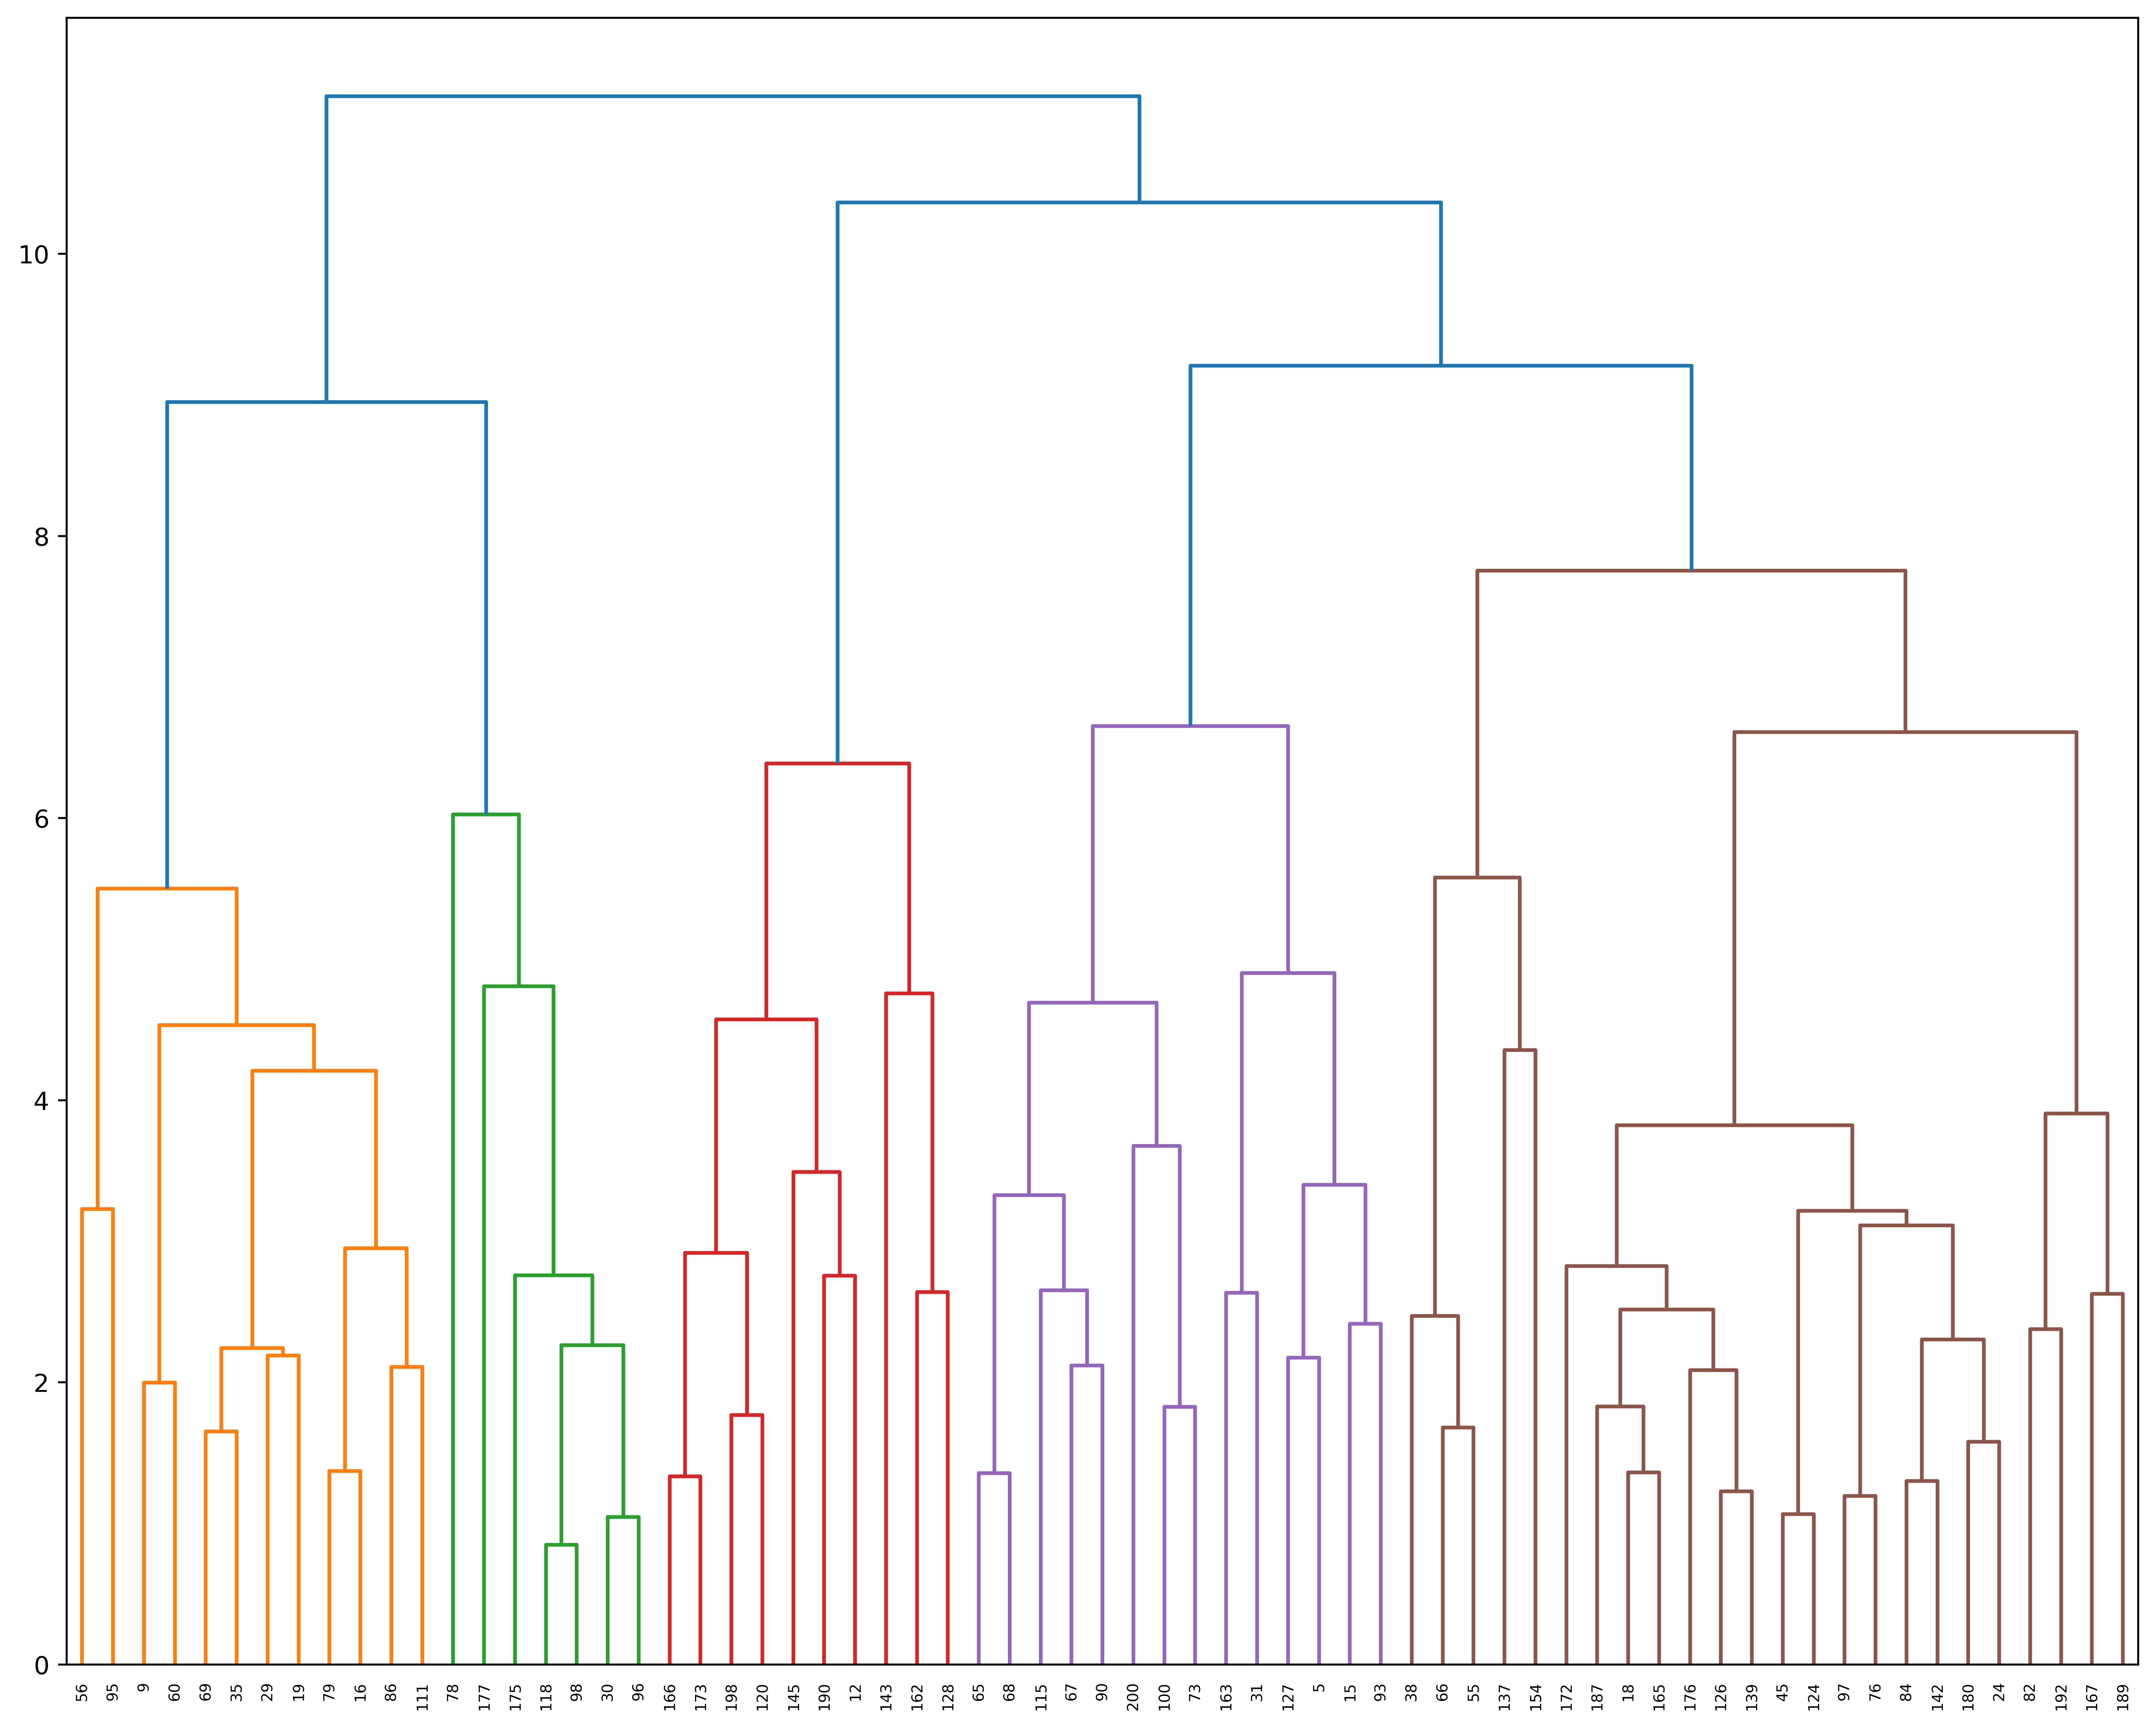

In [38]:
plt.figure(figsize=(15, 12))
np.random.seed(42) 
dendrogram = sch.dendrogram(
    sch.linkage(sample, method='ward'),
    orientation='top',
    labels= sample.index,
    distance_sort='ascending'
)

Let's select 4 clusters solutions

In [39]:
model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
model.fit(sample)
# add new column with cluster modality
sample["cluster_agg_ward"] = model.labels_
#print cluster distribution
sample["cluster_agg_ward"].value_counts(dropna=False)

cluster_agg_ward
1    24
0    19
3    14
2    10
Name: count, dtype: int64

In [40]:
sample.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std,cluster_agg_ward
15,-2.039648,-0.505445,1.602424,-0.675739,1.507254,-1.784469,-0.282394,-0.775290,3
9,1.117514,0.231343,-0.341870,1.084287,-0.599348,-1.565586,1.291295,-0.445345,0
115,-0.799568,-1.060990,0.246578,-0.676725,0.283557,1.111868,-1.452026,1.204382,3
78,0.095738,-2.665505,2.048995,-0.374142,-4.066142,-0.089921,1.354362,-1.105236,0
66,-1.838725,0.810385,-0.332842,-0.841149,0.739662,1.444819,0.130637,-0.775290,1


Let's calculate cluster centroids

In [41]:
centroids = sample.groupby("cluster_agg_ward").mean().to_numpy()
centroids

array([[ 0.40426382, -0.46643035, -0.39062145,  0.34647819, -0.92487568,
        -0.44971709, -0.67939387, -0.43839871],
       [-0.34134272,  0.04664378,  0.25716773,  0.12100102,  0.25288581,
         0.53026675,  0.66272447, -0.21163365],
       [ 0.69326834,  0.48879072, -0.93511202, -0.04184235,  0.77868594,
         0.15748208,  0.08919648,  1.73229426],
       [ 0.14704401, -0.09137576,  0.84954125, -0.95247393,  0.54008161,
        -0.13607698, -0.91395635, -0.06826455]])

Using the centroids we obtained by a subset of the original dataset, we divide the entire dataset into four clusters using kmeans algorithm

In [42]:
km = KMeans(
    n_clusters=4, 
    init=centroids, ## we give the model the centroids we calculated above
    n_init=1,       # default 10 is overwritten with 1 when you pass initial centers explicitly
    random_state=123,
    max_iter=500,   ## Stop criterion 1: max number of iteration
    tol=0.0001      ## Stop criterion 2: limit in centroid changing 
).fit(transformed_df) ## Apply the model to the dataset with all the 203 observation 

## Have a look at centroids in final clusters
updated_centroids =km.cluster_centers_
updated_centroids


array([[ 0.19842863, -0.40661401, -0.25565206,  0.34761503, -0.83890788,
        -0.22892439, -0.33971573, -0.45143623],
       [-0.26329021,  0.30069964,  0.00319045,  0.35835162,  0.34905616,
         0.62747903,  0.64105103, -0.11641482],
       [ 0.6239371 ,  0.47814368, -0.6966992 , -0.3443421 ,  0.42088379,
        -0.10042033, -0.01365836,  1.56845934],
       [-0.31541303, -0.15867573,  0.83214275, -0.81595253,  0.4462439 ,
        -0.52258778, -0.43615233, -0.19488643]])

In [43]:
transformed_df['cluster_km'] = km.labels_
transformed_df['cluster_km'].value_counts(dropna=False, normalize=True)

cluster_km
1    0.320197
0    0.320197
3    0.216749
2    0.142857
Name: proportion, dtype: float64

In [44]:
transformed_df.head(5)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std,cluster_km
0,-1.507602,1.739829,-1.582117,1.486606,0.348283,1.062008,-1.556853,0.544491,1
1,1.391487,-2.544854,0.984515,-1.204240,-1.370118,0.007769,0.981328,-0.775290,0
2,-0.931165,-2.799004,-0.064289,0.000878,1.282488,-0.194460,-0.795617,-0.775290,3
3,1.563886,0.255569,0.096038,0.181109,-1.236924,-0.503823,0.354931,-0.775290,0
4,0.808124,0.591422,-0.818061,0.075789,0.622085,0.926356,-1.233772,-0.115400,2


Now that we have the cluster centorids, we could proceed with the interpretation. We are not doing it now:
we remove the cluster_km column, because we will do the segmentation with the second method below (plain k-means)

In [45]:
transformed_df.drop(columns=['cluster_km'],inplace=True)

# METHOD 2 
- just one step: run a k-means clustering where the inizial cluster centroids are 
  setted randomly

In [46]:
transformed_df.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std
0,-1.507602,1.739829,-1.582117,1.486606,0.348283,1.062008,-1.556853,0.544491
1,1.391487,-2.544854,0.984515,-1.204240,-1.370118,0.007769,0.981328,-0.775290
2,-0.931165,-2.799004,-0.064289,0.000878,1.282488,-0.194460,-0.795617,-0.775290
3,1.563886,0.255569,0.096038,0.181109,-1.236924,-0.503823,0.354931,-0.775290
4,0.808124,0.591422,-0.818061,0.075789,0.622085,0.926356,-1.233772,-0.115400


In [47]:
km_rand_init = KMeans(
    n_clusters=4, 
    n_init=4,
    random_state=123,
    max_iter=300,
    tol=0.01,
).fit(transformed_df)

new_centroids =km_rand_init.cluster_centers_
new_centroids

array([[ 0.82039109,  0.27522874, -0.46327888, -0.16848678,  0.35628871,
         0.1152273 ,  0.43096238,  1.38273056],
       [ 0.33637998, -0.58726034,  0.0379792 ,  0.35540879, -0.43062295,
         0.19638972, -0.08252005, -0.51221385],
       [-0.72122923,  0.37447031,  0.244678  , -0.42767859,  0.38780892,
         0.64942085, -0.10763482, -0.05552063],
       [-0.44963757,  0.36863961,  0.02919639,  0.07224313, -0.04939576,
        -1.46111797, -0.10660335, -0.26342913]])

In [48]:
# add new column with cluster modality
transformed_df['cluster_km'] = km_rand_init.labels_
#print cluster distribution
transformed_df['cluster_km'].value_counts(dropna=False, normalize=True)

cluster_km
1    0.369458
2    0.266010
3    0.182266
0    0.182266
Name: proportion, dtype: float64

In [49]:
transformed_df.head()

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std,cluster_km
0,-1.507602,1.739829,-1.582117,1.486606,0.348283,1.062008,-1.556853,0.544491,2
1,1.391487,-2.544854,0.984515,-1.204240,-1.370118,0.007769,0.981328,-0.775290,1
2,-0.931165,-2.799004,-0.064289,0.000878,1.282488,-0.194460,-0.795617,-0.775290,1
3,1.563886,0.255569,0.096038,0.181109,-1.236924,-0.503823,0.354931,-0.775290,1
4,0.808124,0.591422,-0.818061,0.075789,0.622085,0.926356,-1.233772,-0.115400,2


## Cluster interpretation ###

First, let's verify if the variables differ between clusters by means of ANOVA 

In [50]:
def test_equality_of_means(df, var):

    df_cl_0 = df[df.cluster_km == 0][var]
    df_cl_1 = df[df.cluster_km == 1][var]
    df_cl_2 = df[df.cluster_km == 2][var]
    df_cl_3 = df[df.cluster_km == 3][var]

    fvalue, pvalue = stats.f_oneway( 
        df_cl_0, # cluster_0
        df_cl_1, # cluster_1
        df_cl_2, # cluster_2
        df_cl_3  # cluster_3
    )
    result_dict = {}
    result_dict["var"] = var
    result_dict["f_statistic"] = fvalue
    result_dict["p_value"] = pvalue
    return result_dict

In [51]:
vars = [
    "Factor_1",
    "Factor_2",
    "Factor_3",
    "Factor_4",
    "Factor_5",
    "Factor_6",
    "Factor_7",
    "Q17_std"
]

for var in vars:
    print(test_equality_of_means(transformed_df, var))


{'var': 'Factor_1', 'f_statistic': 34.125761897025, 'p_value': 7.710278754108554e-18}
{'var': 'Factor_2', 'f_statistic': 16.92627543442711, 'p_value': 7.841378814590555e-10}
{'var': 'Factor_3', 'f_statistic': 3.9151333719840795, 'p_value': 0.009568309666674435}
{'var': 'Factor_4', 'f_statistic': 7.489243800579342, 'p_value': 8.945953654986435e-05}
{'var': 'Factor_5', 'f_statistic': 10.09635841732926, 'p_value': 3.19702785011068e-06}
{'var': 'Factor_6', 'f_statistic': 71.28089536904739, 'p_value': 2.384864598613461e-31}
{'var': 'Factor_7', 'f_statistic': 2.8735002811430372, 'p_value': 0.037401084478134144}
{'var': 'Q17_std', 'f_statistic': 56.769370103364366, 'p_value': 1.47270354095165e-26}


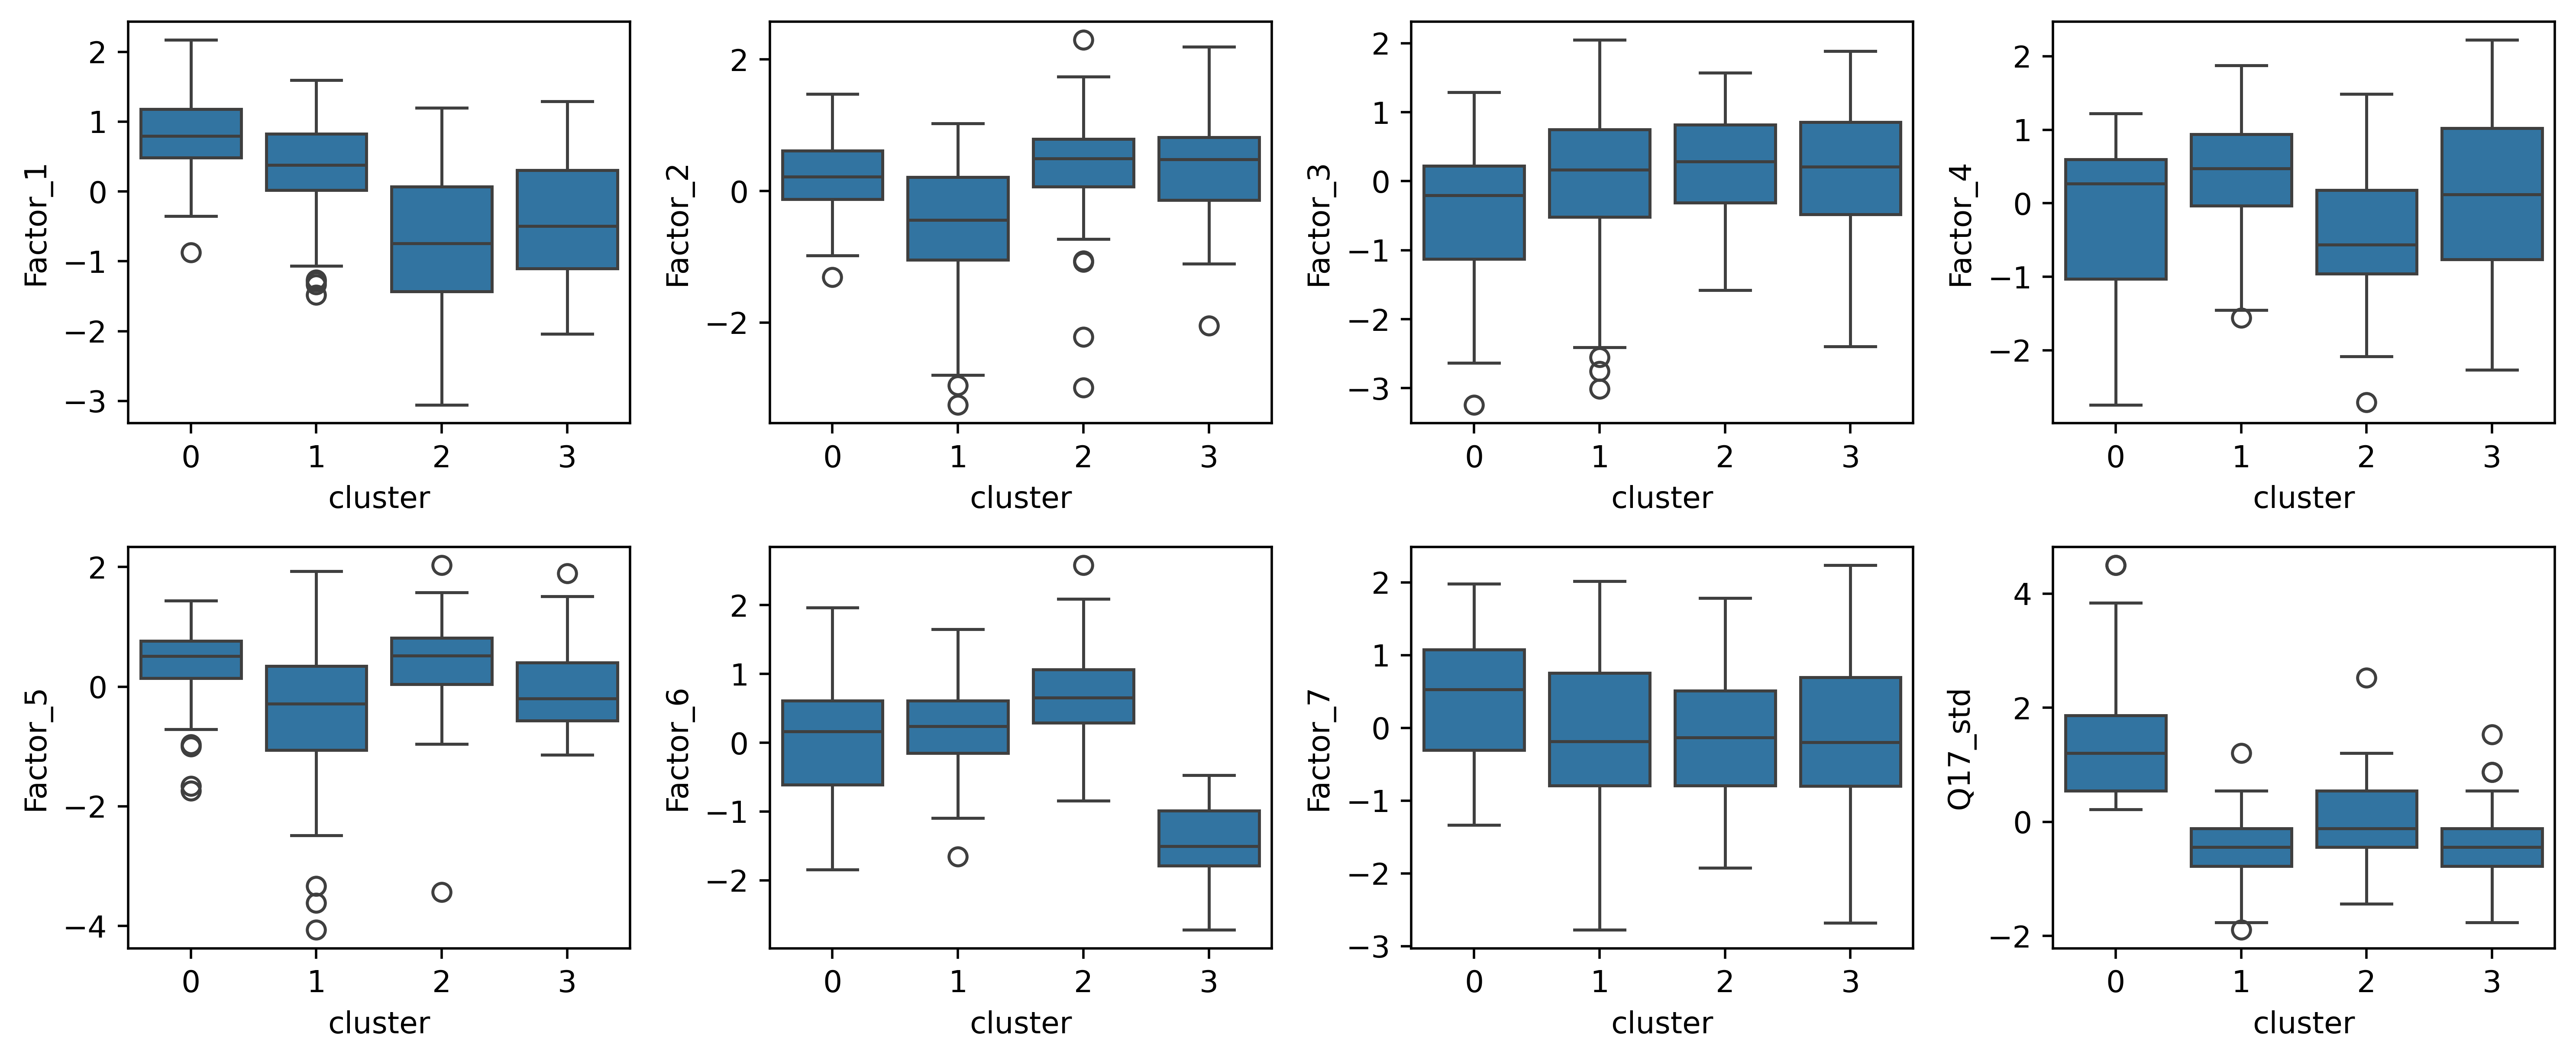

In [52]:
fig, axes = plt.subplots(2,4,figsize=(12,5))
plt.rcParams['figure.dpi'] =1000
for var, ax in zip(vars, axes.flatten()):
    sb.boxplot(x="cluster_km", y=var, data=transformed_df, orient='v', ax=ax)
    ax.set(xlabel="cluster")
fig.tight_layout()

In [53]:
clusters_summary = transformed_df.groupby("cluster_km").mean()
display(clusters_summary)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std
cluster_km,,,,,,,,
0,0.820391,0.275229,-0.463279,-0.168487,0.356289,0.115227,0.430962,1.382731
1,0.336380,-0.587260,0.037979,0.355409,-0.430623,0.196390,-0.082520,-0.512214
2,-0.721229,0.374470,0.244678,-0.427679,0.387809,0.649421,-0.107635,-0.055521
3,-0.449638,0.368640,0.029196,0.072243,-0.049396,-1.461118,-0.106603,-0.263429


In [54]:
#clusters_summary.to_csv('clusters_summary_v1.csv')

In [55]:
clusters_summary

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std
cluster_km,,,,,,,,
0,0.820391,0.275229,-0.463279,-0.168487,0.356289,0.115227,0.430962,1.382731
1,0.336380,-0.587260,0.037979,0.355409,-0.430623,0.196390,-0.082520,-0.512214
2,-0.721229,0.374470,0.244678,-0.427679,0.387809,0.649421,-0.107635,-0.055521
3,-0.449638,0.368640,0.029196,0.072243,-0.049396,-1.461118,-0.106603,-0.263429


Let's visualize the clusters to get an insight about them...

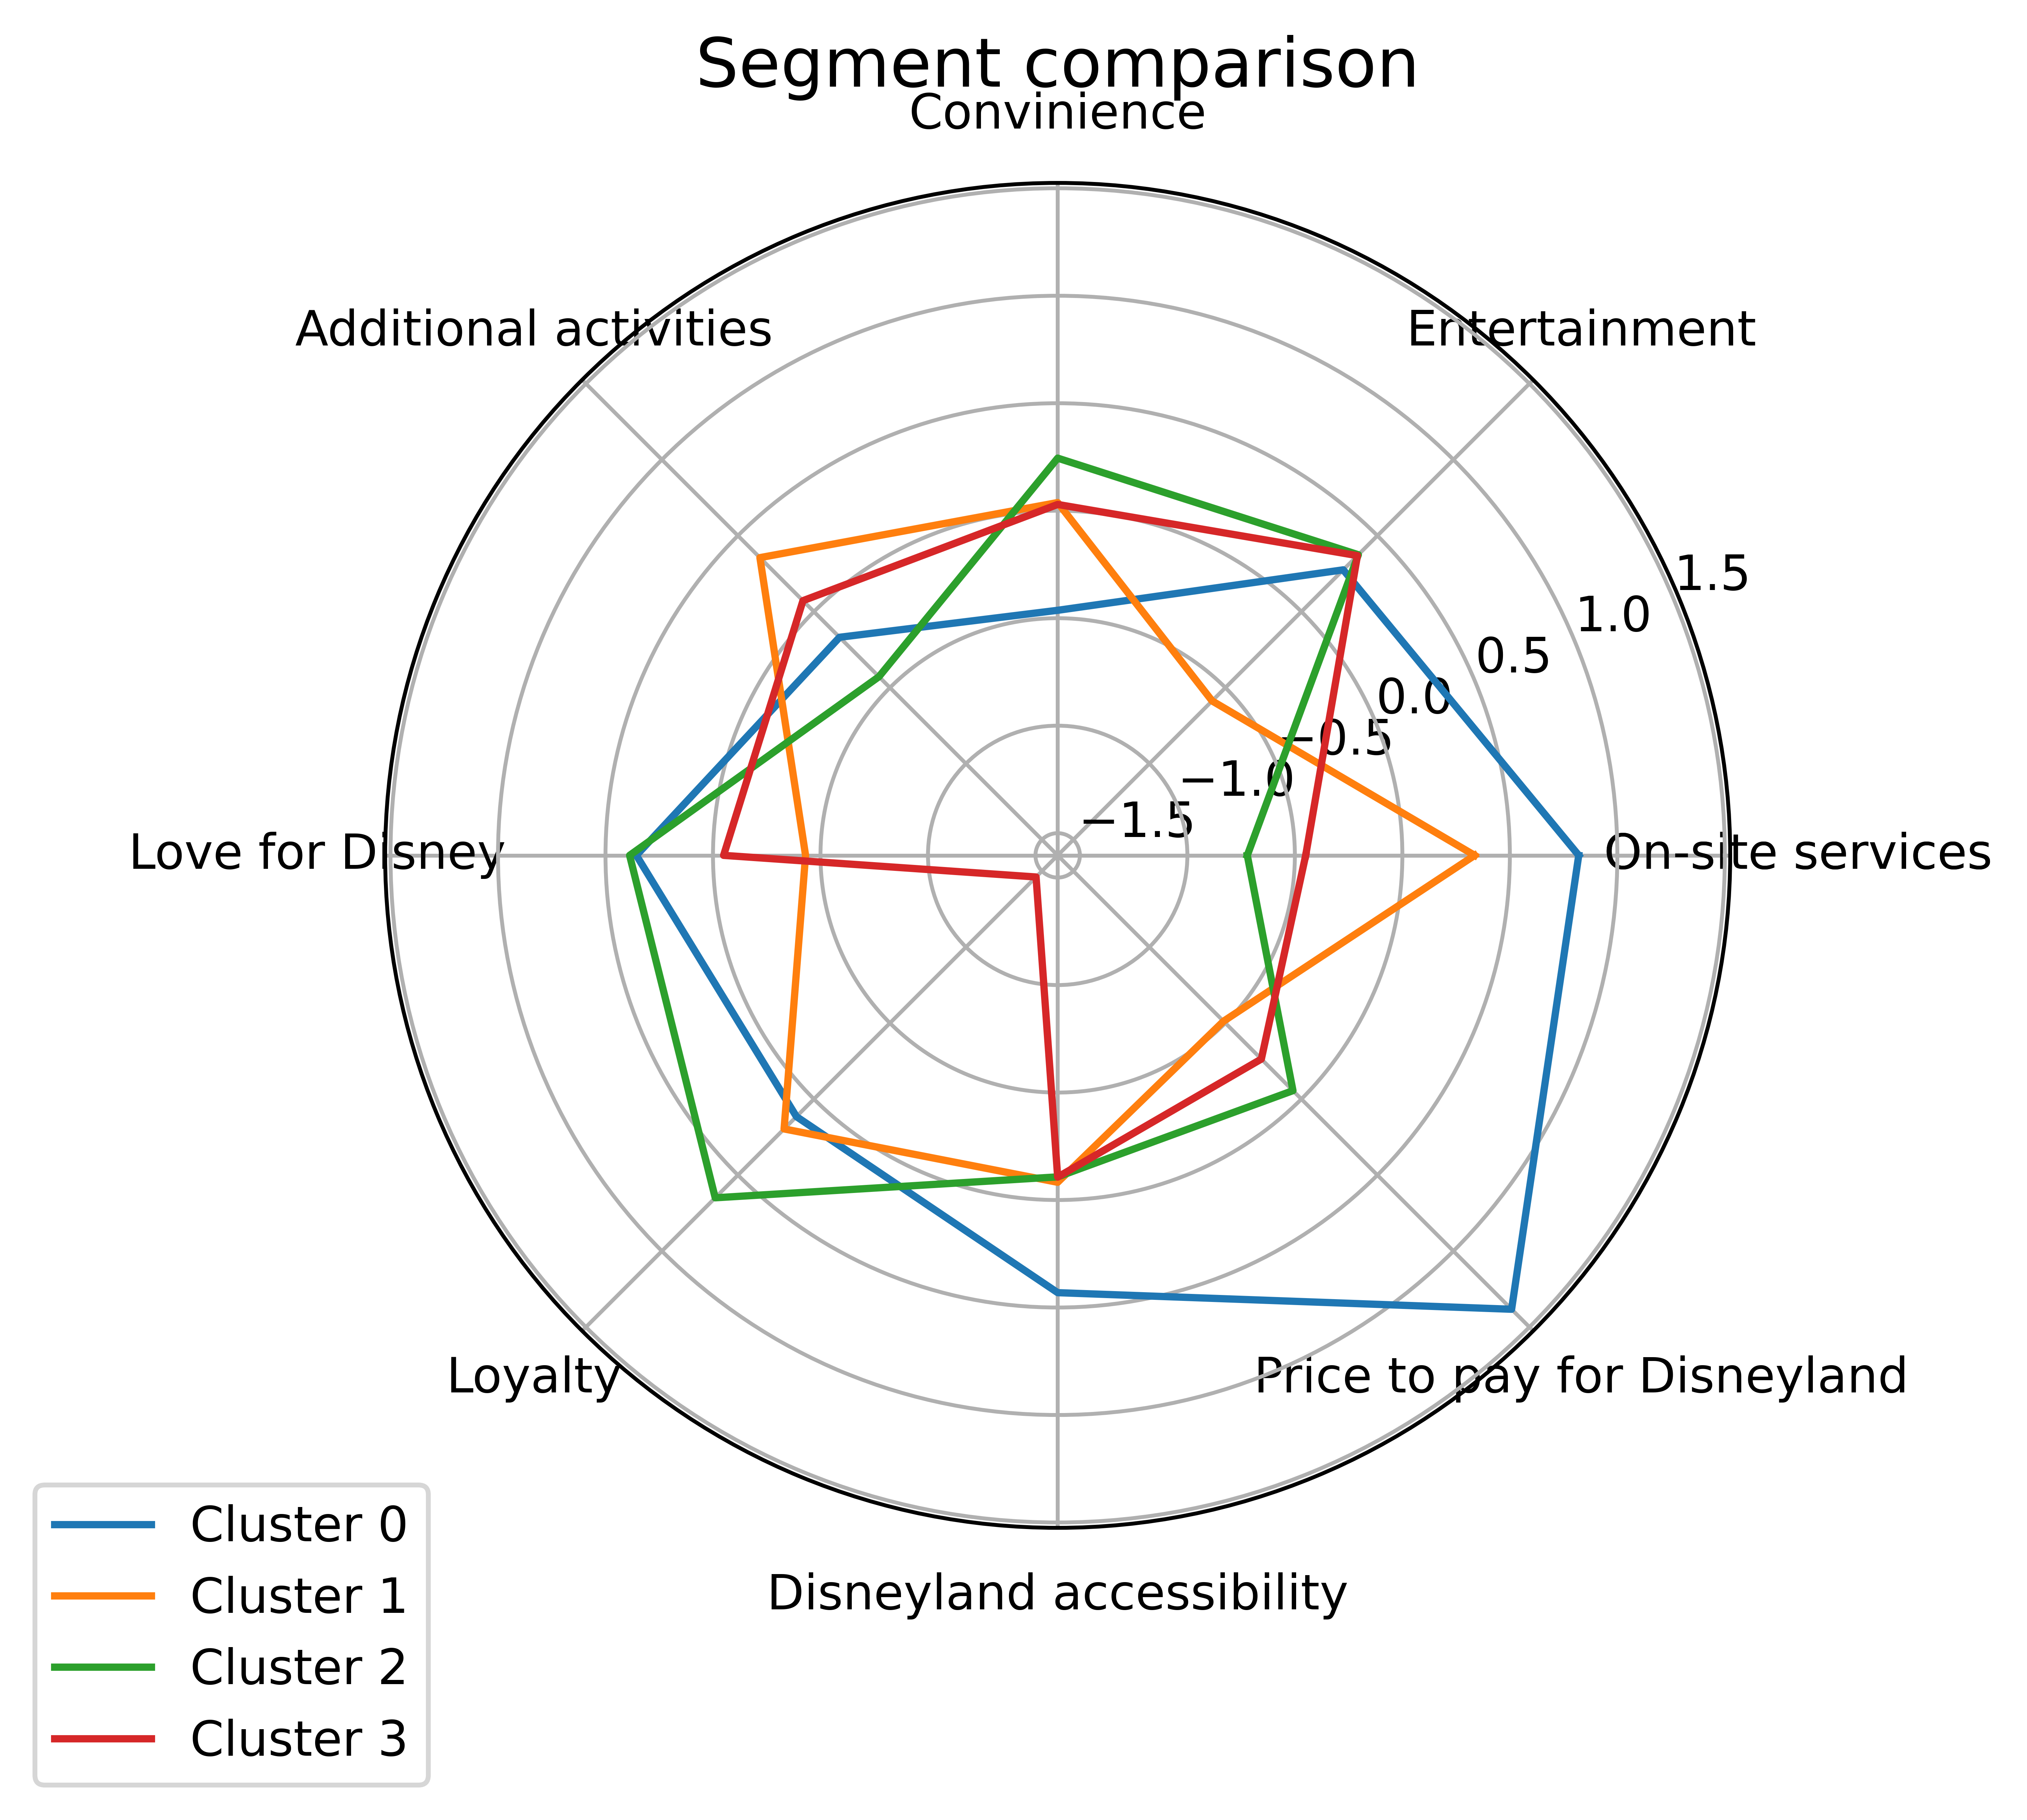

cluster_km
1    0.369458
2    0.266010
3    0.182266
0    0.182266
Name: proportion, dtype: float64

In [56]:
categories = [
    'On-site services', 
    'Entertainment', 
    'Convinience', 
    'Additional activities',
    'Love for Disney',
    'Loyalty',
    'Disneyland accessibility',
    'Price to pay for Disneyland'
]
#aggiungo l'ultimo valore uguale al primo per "chiudere il cerchio"
categories = [*categories, categories[0]]
cluster_0 = [*clusters_summary.iloc[0], clusters_summary.iloc[0,0]]
cluster_1 = [*clusters_summary.iloc[1], clusters_summary.iloc[1,0]]
cluster_2 = [*clusters_summary.iloc[2], clusters_summary.iloc[2,0]]
cluster_3 = [*clusters_summary.iloc[3], clusters_summary.iloc[3,0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=9)

plt.figure(figsize=(5, 5))
plt.subplot(polar=True)
plt.plot(label_loc, cluster_0, label='Cluster 0')
plt.plot(label_loc, cluster_1, label='Cluster 1')
plt.plot(label_loc, cluster_2, label='Cluster 2')
plt.plot(label_loc, cluster_3, label='Cluster 3')

plt.title('Segment comparison', size=14, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.05, 0.05))
plt.show()

transformed_df["cluster_km"].value_counts(normalize=True)

In [57]:
len(label_loc)

9

In [58]:
clusters_summary

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,Q17_std
cluster_km,,,,,,,,
0,0.820391,0.275229,-0.463279,-0.168487,0.356289,0.115227,0.430962,1.382731
1,0.336380,-0.587260,0.037979,0.355409,-0.430623,0.196390,-0.082520,-0.512214
2,-0.721229,0.374470,0.244678,-0.427679,0.387809,0.649421,-0.107635,-0.055521
3,-0.449638,0.368640,0.029196,0.072243,-0.049396,-1.461118,-0.106603,-0.263429


Now we can describe the clusters:

Cluster 0 (blu): 'Disneyland best friends' (36% of the entire sample) 

				People belonging to this cluster love to have fun.
				Indeed, they are driven to go to theme parks for entertainment.
				As a result, they are willing to devote a lot of money to this 
				kind of activities, showing little interest for discounts and 
				promotions. They like Disney, albeit not as much as 
				“More Disney than Land”. Finally, they perceive Disneyland as 
				accessible.

         
Cluster 1 (arancione): 'Disney haters' (26% of the entire sample)

				These people do not like Disney at all and thus are not interested 
				in going to a Disneyland theme park. Should they ever go there, 
				they would spend the whole time sitting in a bar or walking in the 
				shops, trying to kill time. Indeed, they do not particulary like attractions 
				(enertainment) and, as a consequence, their willingness to pay to
				enter Disneyland is very low
                
Cluster 2 (verde): 'More Disney than friends' (18% of the entire sample)

				People belonging to this cluster are huge fans of Disney,
				but they don’t like theme parks that much. 
				Therefore, they are not so interested in additional activities. 
				Their willingness to pay is not so high.

Cluster 3 (rosso): 'Entertainment enthusiasts' (18% of the entire sample)

    			People who belong to this cluster love to have fun. Indeed, they are driven to go 
                to theme parks for entertainments. Once they are in an entertainment land, they 
                will not pass their time sitting in bars nor in additional activities, since they are 
                probably more interested in carousel then in events.


     


In [59]:
# Mapping dictionary
cluster_mapping = {
    0: "Disneyland best friends",
    1: "Disney haters",
    2: "More Disney than friends",
    3: "Entertainment enthusiasts"
}

# Replace the values in the 'cluster_km' column
transformed_df['cluster'] = transformed_df['cluster_km'].replace(cluster_mapping)

transformed_df["cluster"].value_counts(normalize=True, dropna=False)

cluster
Disney haters                0.369458
More Disney than friends     0.266010
Entertainment enthusiasts    0.182266
Disneyland best friends      0.182266
Name: proportion, dtype: float64

## CLuster description
TEST FOR DIFFERENCES BETWEEN CLUSTERS AND  OTHER VARIABLES

In [60]:
## TEST FOR DIFFERENCIES IN OTHER VARIABLES
#First, add the variables we want to observe (how are they distributed in clusters?)

transformed_df_ = (
    transformed_df
    .join(survey[[
        'Age_Range', 
        'Q21', 
        'Q22', 
        'Q23', 
        'Q26_1', 
        'Q26_2',
        'Q26_3', 
        'Q26_4', 
        'Q26_5', 
        'Q26_6', 
        'Q13', 
        'Q18']])
)


In [61]:
##Define a function to perform a chi squared test of hypotesisy for statistical dependency
#The function is written to take as input a two way table

def chi_sq_test(contingeny_table):

    stat, p, dof, expected = stats.chi2_contingency(contingency_table)
    #the function contingency generates 4 output: the chsq value (stat), the pvalue, the deggree of freedom and the 
    #distribution of expected frequencies

    # interpret test-statistic
    prob = 0.95

    print('p-value',p )
    # interpret p-value
    alpha = 1.0 - prob
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

    #insted of p-value I can comput the Chi square statistics associated to the pth percentile
    #critical = stats.chi2.ppf(prob, dof)
    # calculates the probability associated with the chisq value given the degree of freedom and the selected 
    # critical level (0.95%)
    #if abs(stat) >= critical:
    #    print('Dependent (reject H0)')
    #else:
    #    print('Independent (fail to reject H0)')


In [62]:
# Age #
contingency_table = pd.crosstab(transformed_df_.Age_Range, transformed_df_.cluster)
chi_sq_test(contingency_table)
contingency_table

# se p-value <0.05 dipendenti, ha senso tenerlo in considerazione

p-value 0.037619605395412856
Dependent (reject H0)


cluster,Disney haters,Disneyland best friends,Entertainment enthusiasts,More Disney than friends
Age_Range,,,,
b'18-29 years old',14,11,7,18
b'30-40 years old',15,11,13,19
b'41-55 years old',46,15,17,17


In [63]:
# Gender # 
contingency_table = pd.crosstab(transformed_df_.Q21, transformed_df_.cluster)
chi_sq_test(contingency_table)
contingency_table

p-value 0.08382286171103934
Independent (fail to reject H0)


cluster,Disney haters,Disneyland best friends,Entertainment enthusiasts,More Disney than friends
Q21,,,,
b'Female',36,25,16,33
b'Male',39,12,21,21


In [64]:
# Occupation # 
contingency_table = pd.crosstab(transformed_df_.Q22, transformed_df_.cluster)
chi_sq_test(contingency_table)
contingency_table

p-value 0.5089229835881299
Independent (fail to reject H0)


cluster,Disney haters,Disneyland best friends,Entertainment enthusiasts,More Disney than friends
Q22,,,,
b'Employee',38,13,20,27
b'Employer',4,3,1,1
b'Freelance',14,5,7,5
b'Student',14,11,7,17
b'Unemployed',5,5,2,4


In [65]:
# Family Size # 
contingency_table = pd.crosstab(transformed_df_.Q23, transformed_df_.cluster)
chi_sq_test(contingency_table)
contingency_table

p-value 0.09375129246073441
Independent (fail to reject H0)


cluster,Disney haters,Disneyland best friends,Entertainment enthusiasts,More Disney than friends
Q23,,,,
b'1',26,10,13,10
b'2',21,4,6,11
b'More than 2',4,2,1,1
b'None',24,21,17,32


In [66]:
# Ever been to Disneyland ? # 
contingency_table = pd.crosstab(transformed_df_.Q13, transformed_df_.cluster)
chi_sq_test(contingency_table)
contingency_table

p-value 0.00019147120003417049
Dependent (reject H0)


cluster,Disney haters,Disneyland best friends,Entertainment enthusiasts,More Disney than friends
Q13,,,,
b'No',54,11,25,30
b'Yes',21,26,12,24


In [67]:
# Would you go to Disneyland if it opened in Milan? #
contingency_table = pd.crosstab(transformed_df_.Q18, transformed_df_.cluster)
chi_sq_test(contingency_table)
#even if not significant, let's show the relationship aniway
contingency_table

p-value 0.08464415532164038
Independent (fail to reject H0)


cluster,Disney haters,Disneyland best friends,Entertainment enthusiasts,More Disney than friends
Q18,,,,
b'No',10,0,4,3
b'Yes',65,37,33,51


In [68]:
## If we want to test if a quantitative variables is distributed differentially between cluster, we need to perform 
## an ANOVA test. So we write a function to do this
def test_equality_of_means_v2(df, var):

    df_cl_0 = df[df.cluster_km == 0][var]
    df_cl_1 = df[df.cluster_km == 1][var]
    df_cl_2 = df[df.cluster_km == 2][var]
    df_cl_3 = df[df.cluster_km == 3][var]

    fvalue, pvalue = stats.f_oneway( 
        df_cl_0, # cluster_0
        df_cl_1, # cluster_1
        df_cl_2, # cluster_2
        df_cl_3  # cluster_3
    )
    
    result_dict = {}
    result_dict["var"] = var
    result_dict["f_statistic"] = fvalue
    result_dict["p_value"] = pvalue
    
    df_mean = (
        transformed_df_
        .groupby("cluster")[[var]]
        .mean()
        .reset_index()
        .set_index("cluster")
        .rename(columns = {var: "mean_" + var})
    )
        
    df_std = (
        transformed_df_
        .groupby("cluster")[[var]]
        .std()
        .reset_index()
        .set_index("cluster")
        .rename(columns = {var: "std_" + var})
    )
     
    print(df_mean.join(df_std))
        
    return result_dict

In [69]:
# Distribution between clusters of quantitative variables: interviewed feelings about some statements

In [70]:
# Psychographics #
labels = [
    "How much do you agree with the following statements? (I like cartoons)",
    "How much do you agree with the following statements? (I'd like to go in a magic place)",
    "How much do you agree with the following statements? (looking for an adrenalinic experience)",
    "How much do you agree with the following statements? (I miss my childhood)",
    "How much do you agree with the following statements? (I'm extrovert)",
    "How much do you agree with following statements? (I like happy ending's tales)"   
]


vars = [
    "Q26_1",
    "Q26_2",
    "Q26_3", # How much do you agree with the following statements? (looking for an adrenalinic experience)
    "Q26_4", # How much do you agree with the following statements? (I miss my childhood)
    "Q26_5", # How much do you agree with the following statements? (I'm extrovert)
    "Q26_6"  # How much do you agree with following statements? (I like happy ending's tales)
]

for var in vars:
    print(labels[vars.index(var)]) #print the label in labes list which is in the same position of the variable in variables list
    print(test_equality_of_means_v2(transformed_df_, var)) # execute the test on the given variable 


How much do you agree with the following statements? (I like cartoons)
                           mean_Q26_1  std_Q26_1
cluster                                         
Disney haters                8.413333   1.794084
Disneyland best friends      8.891892   1.646272
Entertainment enthusiasts    8.216216   1.618215
More Disney than friends     8.981481   1.498310
{'var': 'Q26_1', 'f_statistic': 2.2985120131182195, 'p_value': 0.0787023856260431}
How much do you agree with the following statements? (I'd like to go in a magic place)
                           mean_Q26_2  std_Q26_2
cluster                                         
Disney haters                7.786667   2.483967
Disneyland best friends      9.216216   1.108932
Entertainment enthusiasts    7.621622   2.476011
More Disney than friends     8.685185   1.587975
{'var': 'Q26_2', 'f_statistic': 5.853911073961666, 'p_value': 0.000751078106878981}
How much do you agree with the following statements? (looking for an adrenalinic experi